In [56]:
import json
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
nis_unfiltered=json.load(open("nis_results.json"))
nis=[]

#remove any runs that aren't finished
for d in nis_unfiltered:
  if 'results' in d['qmc']['dmc'].keys():
    nis.append(d)

In [57]:
#K-point averaging. Since we always ran without symmetry, these should all be equal weight.
for d in nis:
  #print(d['qmc']['dmc'])
  res=d['qmc']['dmc']['results']
  nkpts=len(res)
  avg_en=0
  err=0
  for i in res:
    avg_en+=i['energy'][0]
    err+=i['energy'][1]**2
  d['qmc']['dmc']['total_energy']=avg_en/nkpts
  d['qmc']['dmc']['total_energy_err']=sqrt(err)/nkpts
  print(d['control']['id'],d['qmc']['dmc']['total_energy'],d['qmc']['dmc']['total_energy_err'])

1_Ni -170.501505225 0.0010724824656064898
3_Ni -170.550927825 0.001147563384393595
6_Ni3S2 -531.4915587625001 0.001887454267782487
12_Ni3S2 -531.4902262125 0.0023354017105196205
13_Ni3S2 -531.4975062374999 0.0023716400411248266
16_Ni3S4 -1103.5725629999997 0.0026676401617178555
17_Ni3S4 -1103.2081045000002 0.002948002739617797
27_Ni3S4 -1103.606204125 0.0029999683345369875
30_Ni3S4 -1103.610705625 0.005465006721740524
44_NiS -541.6966116125 0.0022266615298708278
45_NiS -541.70685635 0.0020449381856337085
46_NiS -541.7052364 0.0021911792265290257
48_NiS2 -763.1446919624999 0.002418221378257987
49_NiS2 -763.20960145 0.0026247850054639315
51_NiS2 -762.5978082375 0.0025763058175801677
52_NiS2 -763.1993721875 0.002834077577734398
53_NiS2 -763.2194378375 0.0027808211110948032
54_NiS2 -763.211997725 0.0023013418997916858
55_NiS2 -763.2106622375 0.0022886172753883677
56_NiS2 -763.1976572250001 0.002764687840418893
57_NiS2 -763.211661825 0.0025405660755706957
58_S -326.9702109125 0.005098636426

In [59]:
#extract elements from the CIFs
from pymatgen.io.cifio import CifParser
from pymatgen.entries.computed_entries import ComputedStructureEntry
from io import StringIO
computed_structures=[]
for d in nis:
  parser=CifParser(StringIO(d['cif']))
  struct=parser.get_structures()[0]
  sites=struct.as_dict()['sites']
  elements=[]
  for s in sites:
    elements.append(s['species'][0]['element'])
  #print(elements)
  nsupercell=int(np.linalg.det(d['supercell'])+0.5) #round..
  #print("supercell",nsupercell)
  super_elements=[]
  for i in range(0,nsupercell):
    super_elements.extend(elements)
  #print("elements",super_elements)
  d['elements']=super_elements
  


In [65]:
#find the reference energy for each atom. For now, we'll just 
#set the energy to the first instance of the pure material
references={}
for d in nis:
  if len(set(d['elements']))==1:# and not d['elements'][0] in references.keys():
    natoms=len(d['elements'])
    references[d['elements'][0]]=d['qmc']['dmc']['total_energy']/natoms
print(references)
    

{'S': -10.217751041015624, 'Ni': -170.273924265625}


1_Ni 1 0
3_Ni 1 0
6_Ni3S2 3 2
12_Ni3S2 3 2
13_Ni3S2 3 2
16_Ni3S4 6 8
17_Ni3S4 6 8
27_Ni3S4 6 8
30_Ni3S4 6 8
44_NiS 3 3
45_NiS 3 3
46_NiS 3 3
48_NiS2 4 8
49_NiS2 4 8
51_NiS2 4 8
52_NiS2 4 8
53_NiS2 4 8
54_NiS2 4 8
55_NiS2 4 8
56_NiS2 4 8
57_NiS2 4 8
58_S 0 32
59_S 0 32
60_S 0 32
61_S 0 32
62_S 0 32
63_Ni 8 0


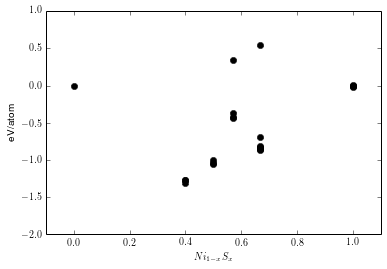

In [72]:
#Make the plot of energy, referenced to the 
x=[]
y=[]
yerr=[]
H2eV=27.2114
for d in nis:
  natoms=len(d['elements'])
  shift=0
  for e in d['elements']:
    shift+=references[e]
  shifted_en=d['qmc']['dmc']['total_energy']-shift
  shifted_err=d['qmc']['dmc']['total_energy_err'] #should probably adjust this
  shifted_en=shifted_en/natoms
  shifted_err=shifted_err/natoms
  n_ni=d['elements'].count("Ni")
  n_s=d['elements'].count("S")
  print(d['control']['id'],n_ni,n_s)
  x.append(float(n_s)/float(n_ni+n_s))
  y.append(H2eV*shifted_en)
  yerr.append(H2eV*shifted_err)
    
plt.errorbar(x,y,yerr,marker="o",lw=0)
plt.xlim(-.1,1.1)
plt.ylim(-2,1)
plt.xlabel("$Ni_{1-x}S_x$")
plt.ylabel("eV/atom")